In [1]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch
import functions.handy_functions as hf

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

2024-04-24 11:11:51.462589: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 11:11:51.496347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 11:11:51.496367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 11:11:51.497227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 11:11:51.502568: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#Set directory of found pairs
main_dir='/cloud/skogsstyrelsen_pairs/'
directories=os.listdir(main_dir)

In [3]:
#Import and format data
ims_all=[]
temporals_all=[]
for dir in directories:
    data_clear=xr.load_dataset(main_dir+dir+'/clear_data.nc', engine='netcdf4', decode_times=True)
    data_cloudy=xr.load_dataset(main_dir+dir+'/cloudy_data.nc', engine='netcdf4', decode_times=True)

    variables=data_clear.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data

    ## Save image ##
    im_clear=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
    im_clear[:,:,0]=b02
    im_clear[:,:,1]=b03
    im_clear[:,:,2]=b04
    im_clear[:,:,3]=b05
    im_clear[:,:,4]=b06
    im_clear[:,:,5]=b07
    im_clear[:,:,6]=b08
    im_clear[:,:,7]=b8a
    im_clear[:,:,8]=b09
    im_clear[:,:,9]=b10
    im_clear[:,:,10]=b11
    im_clear[:,:,11]=b12
    im_clear[:,:,12]=sun_z

    variables=data_cloudy.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data

    ## Save image ##
    im_cloudy=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
    im_cloudy[:,:,0]=b02
    im_cloudy[:,:,1]=b03
    im_cloudy[:,:,2]=b04
    im_cloudy[:,:,3]=b05
    im_cloudy[:,:,4]=b06
    im_cloudy[:,:,5]=b07
    im_cloudy[:,:,6]=b08
    im_cloudy[:,:,7]=b8a
    im_cloudy[:,:,8]=b09
    im_cloudy[:,:,9]=b10
    im_cloudy[:,:,10]=b11
    im_cloudy[:,:,11]=b12
    im_cloudy[:,:,12]=sun_z

    im_pair=[im_clear,im_cloudy]
    ims_all.append(im_pair)
    temporals_all.append([data_clear.coords['t'].data[0],data_cloudy.coords['t'].data[0]])

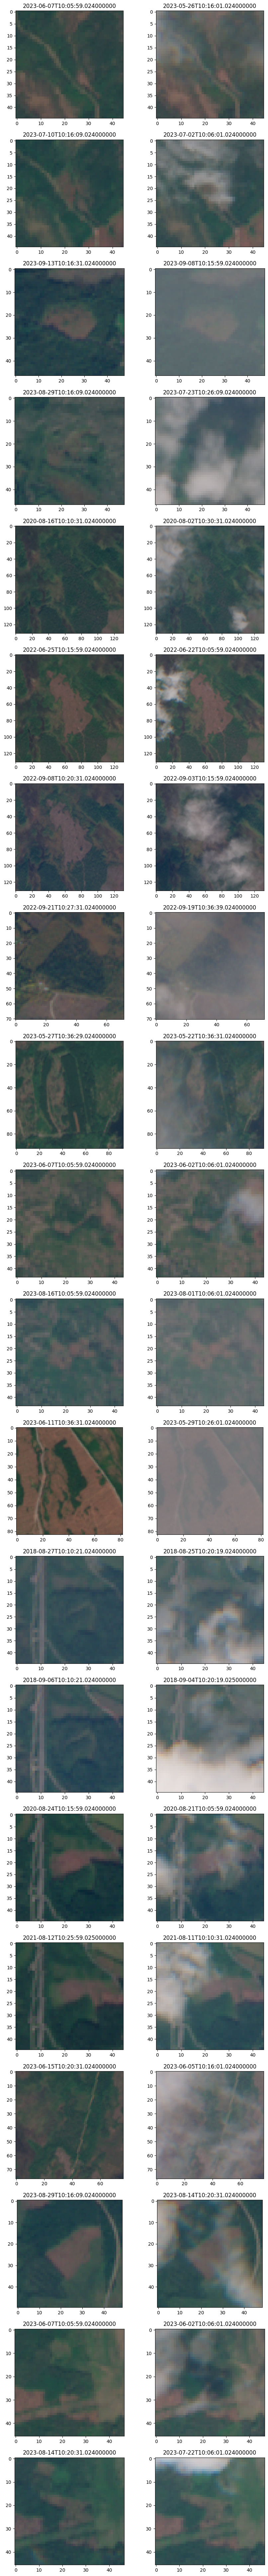

In [4]:
#Plot all clear/cloudy pairs
ncols=2
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title(temporals_all[i][1])
    pair_c+=1

Now import model without COT estimation and predict

In [5]:
main_filepath='pytorch_models/COT_est_inp_noCOT'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
    
quantiles = np.array([0.1,0.5,0.9])
est = np.where(quantiles==0.5)[0].item()

In [6]:
#Make predictions and save with uncertanties

preds_all=[]
uncertainties_all=[]
for i,pair in enumerate(ims_all):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_cloud_r)
        else:   
            pred=pred+model.predict(im_cloud_r)
    pred=pred/len(models)

    ##Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i,est],im_shape_pred[0:2])
        im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

    preds_all.append(im_pred)
    uncertainties_all.append(im_unc)

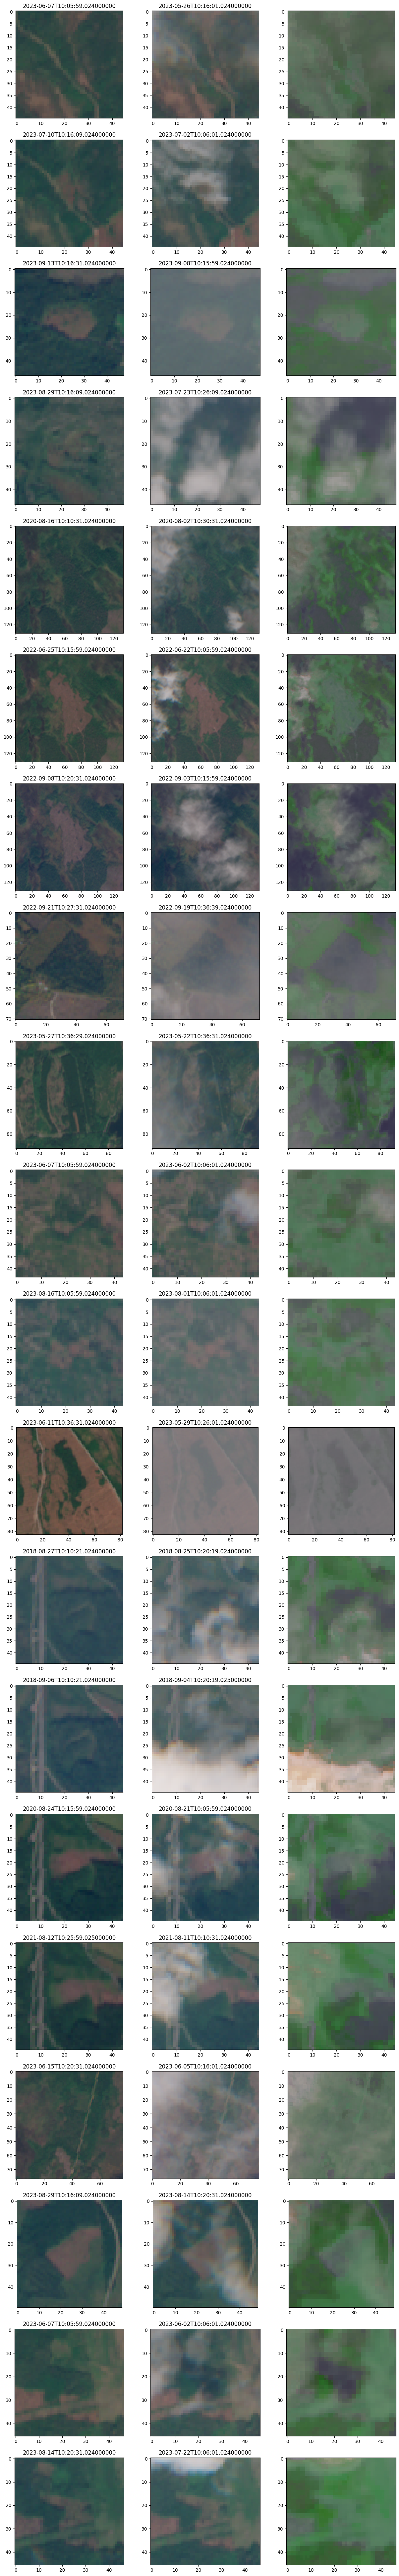

In [7]:
#Print clear, cloudy and predictions
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title(temporals_all[i][1])
    axs[pair_c,2].imshow(hf.Sentinel2TrueColor(preds_all[i]))
    pair_c+=1

In [8]:
#Evaluate through NMSE

n_pairs=len(preds_all)

NMSEs_og=np.zeros((n_pairs,12))
NMSEs_pred=np.zeros((n_pairs,12))

p_c=0
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
    norm_og=np.linalg.norm(np.square((im_clear[:,:,0:12])-(im_cloud[:,:,0:12])),axis=(0,1))**2
    norm_pred=np.linalg.norm(np.square((im_clear[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
    norm_gt=np.linalg.norm(np.square(im_clear[:,:,0:12]),axis=(0,1))**2

    NMSE_og=norm_og/norm_gt
    NMSE_pred=norm_pred/norm_gt

    NMSEs_og[p_c,:]=NMSE_og
    NMSEs_pred[p_c,:]=NMSE_pred
    p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))    

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(mean_NMSE_pred_wo_10)))


NMSE before correction, Band 2: 2.533392167583037
NMSE after correction, Band 2: 0.18776539288535982
 
NMSE before correction, Band 3: 7.04209191588305
NMSE after correction, Band 3: 1.1543904743156823
 
NMSE before correction, Band 4: 38.230500798721565
NMSE after correction, Band 4: 13.469021423244982
 
NMSE before correction, Band 5: 10.200628205921465
NMSE after correction, Band 5: 4.424985712254689
 
NMSE before correction, Band 6: 0.5412580421058555
NMSE after correction, Band 6: 0.22555634781595763
 
NMSE before correction, Band 7: 0.2935400187552653
NMSE after correction, Band 7: 0.13463482490370185
 
NMSE before correction, Band 8: 0.23196569416715768
NMSE after correction, Band 8: 0.13955116318377922
 
NMSE before correction, Band 8A: 0.20877251076065523
NMSE after correction, Band 8A: 0.11102382834899935
 
NMSE before correction, Band 9: 5.034597443354252
NMSE after correction, Band 9: 1.6636366440916777
 
NMSE before correction, Band 10: 36.97200319202124
NMSE after correct

Now perform COT estimation

In [9]:
#For trials with COT est:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load all COT est models
model_load_paths=['smhi_models3/0/model_it_2000000','smhi_models3/1/model_it_2000000', 'smhi_models3/2/model_it_2000000','smhi_models3/3/model_it_2000000', 'smhi_models3/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

#Set training data means and std's for normalization
means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]


In [10]:
#Make COT_predictions and append to cloudy image data, both estimation and thresholded dummies
ims_all_wCOT=[]
ims_all_wCOT_dum=[]
for i,pair in enumerate(ims_all):
    im_clear=pair[0]
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    #Normalize
    inputs = (im_cloud_r - means) / stds

    image_input_tens=torch.Tensor(inputs).to(device)

    #Make predictions
    preds = 0
    for model_cot in models_cot:
        curr_preds=model_cot(image_input_tens)/len(models_cot)
        preds=preds+curr_preds

    image_pred_cot=50*preds.cpu().data.numpy() #unnormalise

    #Sort into categories instead
    t_is_cloud = 0.025*50 #From Pirinen et. al.
    t_thin_cloud = 0.015*50 #From Pirinen et. al.

    pred_clear = np.zeros(image_pred_cot.shape)
    pred_thin = np.zeros(image_pred_cot.shape)
    pred_thick = np.zeros(image_pred_cot.shape)

    pred_clear[image_pred_cot<t_thin_cloud]=1
    pred_thin[(image_pred_cot>=t_thin_cloud)&(image_pred_cot<t_is_cloud)]=1
    pred_thick[image_pred_cot>=t_is_cloud]=1

    # Reshape back
    im_pred_cot=np.reshape(image_pred_cot,[im_shape[0],im_shape[1],1])
    im_pred_clear=np.reshape(pred_clear,[im_shape[0],im_shape[1],1])
    im_pred_thin=np.reshape(pred_thin,[im_shape[0],im_shape[1],1])
    im_pred_thick=np.reshape(pred_thick,[im_shape[0],im_shape[1],1])

    #append COT-est to cloudy image set
    im_cloud_wCOT=np.concatenate((im_cloud,im_pred_cot),axis=2)
    im_pair=[im_clear,im_cloud_wCOT]
    ims_all_wCOT.append(im_pair)

    #append COT-est dummies to cloudy image set
    im_cloud_wCOT_dum=np.concatenate((im_cloud,im_pred_clear,im_pred_thin,im_pred_thick),axis=2)
    im_pair=[im_clear,im_cloud_wCOT_dum]
    ims_all_wCOT_dum.append(im_pair)


    

In [11]:
#Load wCOT model
main_filepath='pytorch_models/COT_est_inp_wCOT'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
 

In [12]:
#Make predictions and save with uncertanties

preds_all=[]
uncertainties_all=[]
for i,pair in enumerate(ims_all_wCOT):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_cloud_r)
        else:   
            pred=pred+model.predict(im_cloud_r)
    pred=pred/len(models)

    ##Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i,est],im_shape_pred[0:2])
        im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

    preds_all.append(im_pred)
    uncertainties_all.append(im_unc)

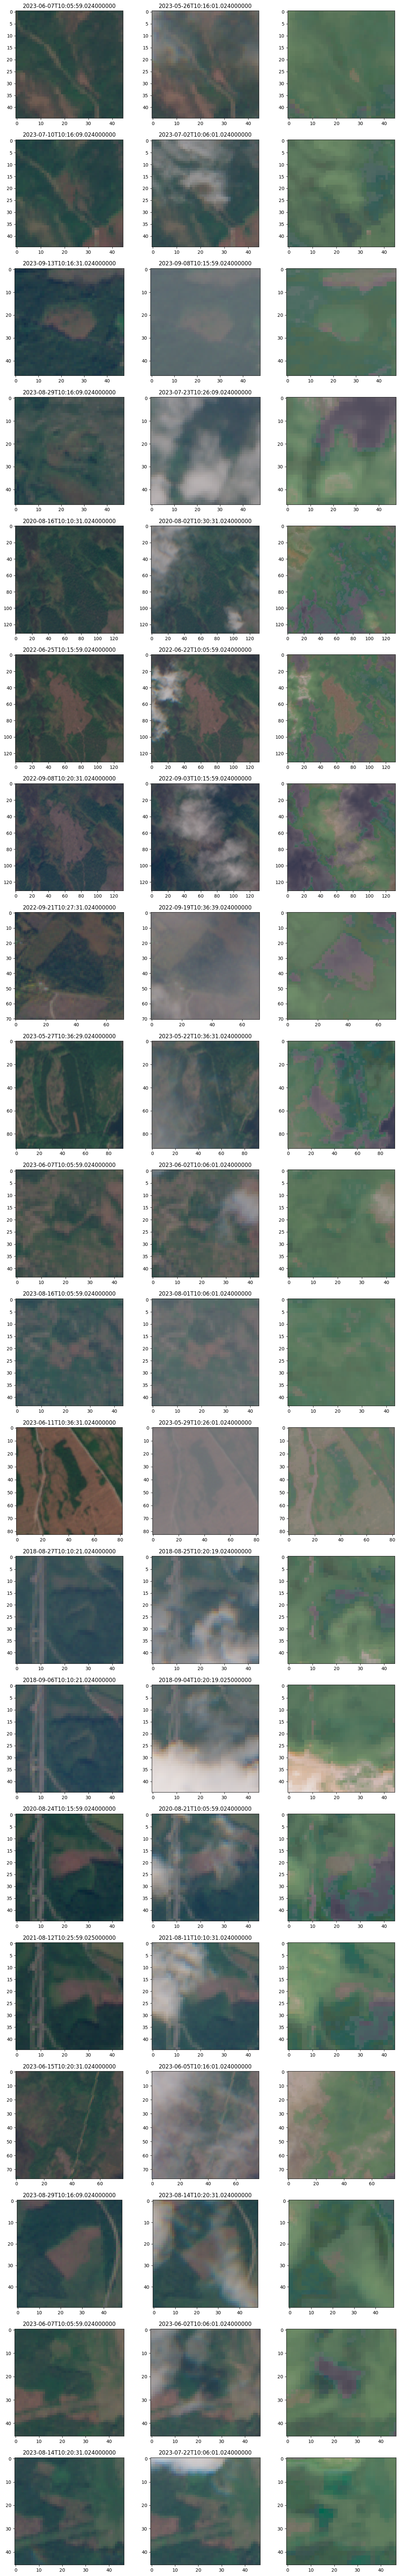

In [13]:
#Print clear, cloudy and predictions
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title(temporals_all[i][1])
    axs[pair_c,2].imshow(hf.Sentinel2TrueColor(preds_all[i]))
    pair_c+=1

In [14]:
#Evaluate through NMSE

n_pairs=len(preds_all)

NMSEs_og=np.zeros((n_pairs,12))
NMSEs_pred=np.zeros((n_pairs,12))

p_c=0
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
    norm_og=np.linalg.norm(np.square((im_clear[:,:,0:12])-(im_cloud[:,:,0:12])),axis=(0,1))**2
    norm_pred=np.linalg.norm(np.square((im_clear[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
    norm_gt=np.linalg.norm(np.square(im_clear[:,:,0:12]),axis=(0,1))**2

    NMSE_og=norm_og/norm_gt
    NMSE_pred=norm_pred/norm_gt

    NMSEs_og[p_c,:]=NMSE_og
    NMSEs_pred[p_c,:]=NMSE_pred
    p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))    

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(mean_NMSE_pred_wo_10)))


NMSE before correction, Band 2: 2.533392167583037
NMSE after correction, Band 2: 0.2387327725199313
 
NMSE before correction, Band 3: 7.04209191588305
NMSE after correction, Band 3: 1.3660278268123056
 
NMSE before correction, Band 4: 38.230500798721565
NMSE after correction, Band 4: 14.480594246011231
 
NMSE before correction, Band 5: 10.200628205921465
NMSE after correction, Band 5: 4.579542921741878
 
NMSE before correction, Band 6: 0.5412580421058555
NMSE after correction, Band 6: 0.3212936243984997
 
NMSE before correction, Band 7: 0.2935400187552653
NMSE after correction, Band 7: 0.177796800453829
 
NMSE before correction, Band 8: 0.23196569416715768
NMSE after correction, Band 8: 0.18381047566355413
 
NMSE before correction, Band 8A: 0.20877251076065523
NMSE after correction, Band 8A: 0.13402007579106565
 
NMSE before correction, Band 9: 5.034597443354252
NMSE after correction, Band 9: 2.185629353281312
 
NMSE before correction, Band 10: 36.97200319202124
NMSE after correction, 

In [15]:
#Load wCOT_dum model
main_filepath='pytorch_models/COT_est_inp_wCOT_dum'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
 

In [16]:
#Make predictions and save with uncertanties

preds_all=[]
uncertainties_all=[]
for i,pair in enumerate(ims_all_wCOT_dum):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_cloud_r)
        else:   
            pred=pred+model.predict(im_cloud_r)
    pred=pred/len(models)

    #Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i,est],im_shape_pred[0:2])
        im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

    preds_all.append(im_pred)
    uncertainties_all.append(im_unc)

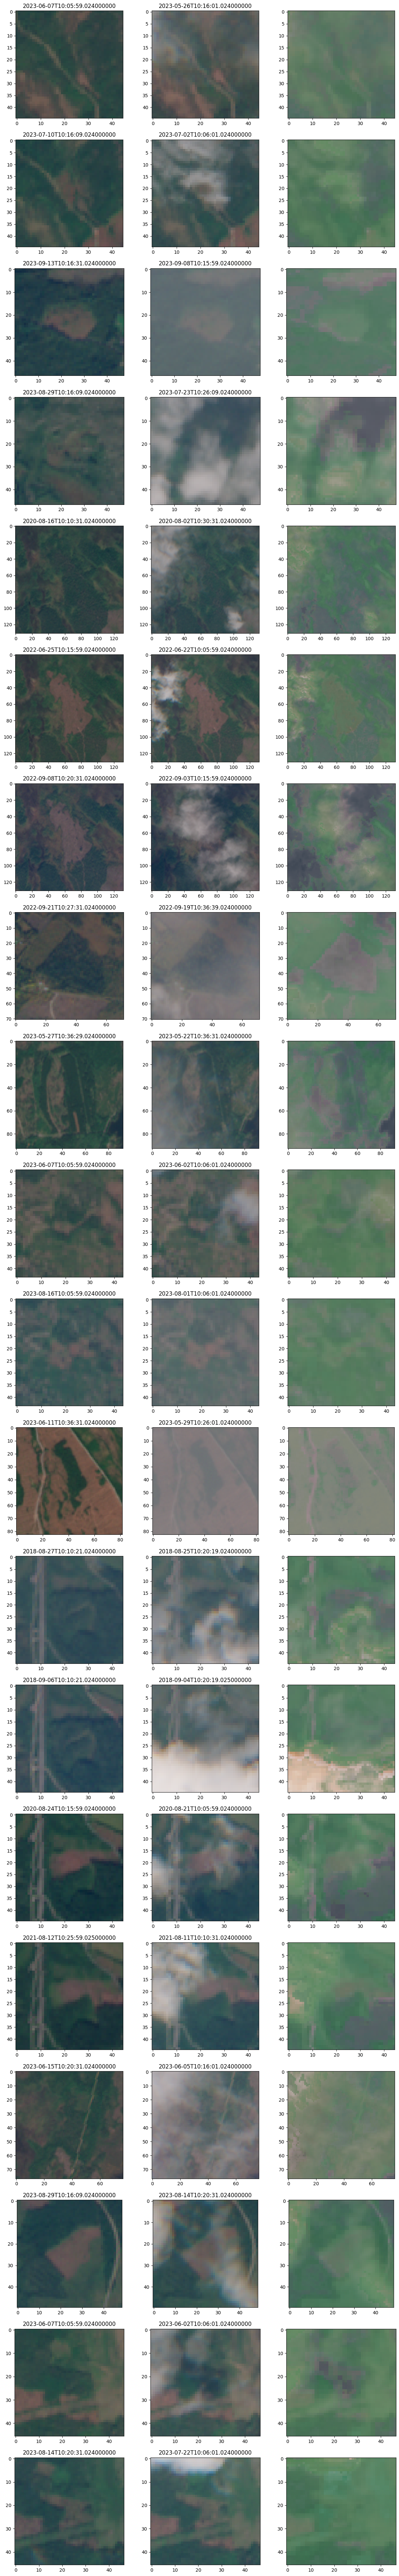

In [17]:
#Print clear, cloudy and predictions
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title(temporals_all[i][1])
    axs[pair_c,2].imshow(hf.Sentinel2TrueColor(preds_all[i]))
    pair_c+=1

In [18]:
#Evaluate through NMSE

n_pairs=len(preds_all)

NMSEs_og=np.zeros((n_pairs,12))
NMSEs_pred=np.zeros((n_pairs,12))

p_c=0
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
    norm_og=np.linalg.norm(np.square((im_clear[:,:,0:12])-(im_cloud[:,:,0:12])),axis=(0,1))**2
    norm_pred=np.linalg.norm(np.square((im_clear[:,:,0:12])-im_pred[:,:,0:12]),axis=(0,1))**2
    norm_gt=np.linalg.norm(np.square(im_clear[:,:,0:12]),axis=(0,1))**2

    NMSE_og=norm_og/norm_gt
    NMSE_pred=norm_pred/norm_gt

    NMSEs_og[p_c,:]=NMSE_og
    NMSEs_pred[p_c,:]=NMSE_pred
    p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))    

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(mean_NMSE_pred_wo_10)))


NMSE before correction, Band 2: 2.533392167583037
NMSE after correction, Band 2: 0.11337005075714623
 
NMSE before correction, Band 3: 7.04209191588305
NMSE after correction, Band 3: 0.8904653521445235
 
NMSE before correction, Band 4: 38.230500798721565
NMSE after correction, Band 4: 9.885241079593843
 
NMSE before correction, Band 5: 10.200628205921465
NMSE after correction, Band 5: 3.4300268274287733
 
NMSE before correction, Band 6: 0.5412580421058555
NMSE after correction, Band 6: 0.23943776982809264
 
NMSE before correction, Band 7: 0.2935400187552653
NMSE after correction, Band 7: 0.14200558451794404
 
NMSE before correction, Band 8: 0.23196569416715768
NMSE after correction, Band 8: 0.1404681739442019
 
NMSE before correction, Band 8A: 0.20877251076065523
NMSE after correction, Band 8A: 0.11068823877831732
 
NMSE before correction, Band 9: 5.034597443354252
NMSE after correction, Band 9: 1.0942252313977936
 
NMSE before correction, Band 10: 36.97200319202124
NMSE after correcti

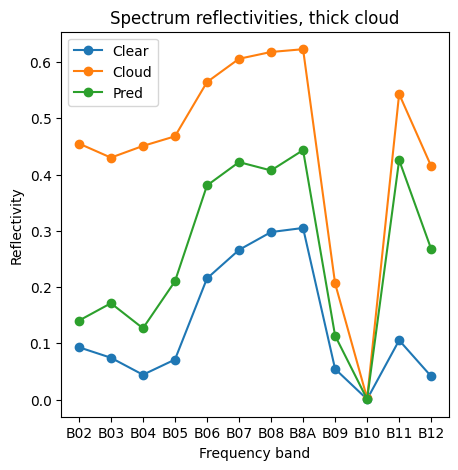

In [21]:
#Plot spectrum of cloudy vs pred vs clear pixel
#Select coords
xy=np.array([0,20])
#Find all band values for coord
clear_xy=im_clear[xy[0],xy[1],:12]
cloud_xy=im_cloud[xy[0],xy[1],:12]
pred_xy=im_pred[xy[0],xy[1],:12]
#unc_xy=np.concatenate(((pred_xy-im_lower[xy[0],xy[1],:]).reshape(1,12),(im_higher[xy[0],xy[1],:]-pred_xy).reshape(1,12)),axis=0)

x=np.arange(np.size(clear_xy))
plt.rcParams['figure.figsize'] = [5,5]
plt.figure()
plt.plot(x,clear_xy,'-o')
plt.plot(x,cloud_xy,'-o')
#plt.errorbar(x,pred_xy,yerr=unc_xy)
plt.plot(x,pred_xy,'-o')

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Spectrum reflectivities, thick cloud')
plt.xlabel('Frequency band')
plt.ylabel('Reflectivity')
plt.legend(['Clear','Cloud','Pred'])
plt.show()

#print('Cloud thickness prediction: '+str(im_pred_cat[xy[0],xy[1]]))

In [20]:
print('hello')

hello
